# Práctica 4: Entrenamiento de redes neuronales

In [132]:
# Library imports

import numpy as np
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import operator
from displayData import displayData
from checkNNGradients import *


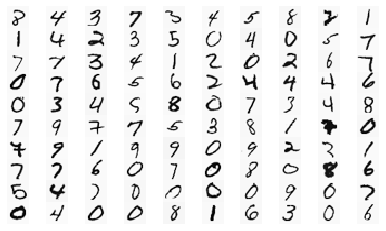

In [139]:
# Loading data
data = loadmat('ex4data1.mat')

y = data['y'].ravel()
X = data['X']
X_ones = np.hstack([np.ones([X.shape[0], 1]), X])

INIT_EPSILON = 0.01

# Loading weights
weights = loadmat('ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

# Displaying data
sample = np.random.choice(X.shape[0], 100)
imgs = displayData(X[sample, :])

In [134]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
    
# Forward propagation
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]

    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [146]:
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def random_weights(L_in, L_out, epsilon = 0.12):
    return np.random.random((L_in, L_out)) * (2 * epsilon) - epsilon

# Gradient function
def gradient(x, y_one):
    random_theta1 = random_weights(25, 401)
    random_theta2 = random_weights(10, 26)

    """print(x)
    print(y_one)

    print(x.shape)
    print(y_one.shape)

    print(random_theta1.shape)
    print(random_theta2.shape)"""

    delta1 = 0
    delta2 = 0

    a1, z2, a2, z3, h = forward_propagate(x, random_theta1, random_theta2)

    for t in range(x.shape[0]):
        a1t = a1[t, :]
        #print(a1t.shape)
        a2t = a2[t, :]
        #print(a2t.shape)
        ht = h[t, :]
        #print(ht.shape)
        yt = y_one[t]
        #print(yt)

        d3t = ht - yt
        d2t = np.dot(random_theta2.T, d3t) * (a2t * (1 - a2t))

        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])

    return np.array([delta1 / x.shape[0] , delta2 / x.shape[0]])

In [151]:
# Cost function
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y_onehot, reg):
    """ backprop devuelve el coste y el gradiente de una red neuronal de dos capas """
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    def cost():
        a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
        m = X.shape[0]

        total = 0
        for i in range(m):
            for k in range(num_etiquetas):
                term_1 = - (np.log(h[i][k]) * y_onehot[i][k])
                term_2 = - (np.log(1 - h[i][k]) * (1 - y_onehot[i][k]))
                total = total + (term_1 + term_2)

        sum_theta1 = np.sum(np.square(theta1))
        sum_theta2 = np.sum(np.square(theta2))

        term_3 = (sum_theta1 + sum_theta2) * (reg / (2 * m))

        return (total / m) + term_3

    return cost(), gradient(X, y_onehot)

## Checkeo del gradiente

In [152]:
params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

a = checkNNGradients(backprop, 0)


AssertionError: 
Arrays are not almost equal to 7 decimals

(shapes (2,), (38,) mismatch)
 x: array([array([[ 0.00024299, -0.00119401,  0.00476528,  0.00634339],
       [ 0.00650961, -0.00152701,  0.00149105,  0.00313825],
       [-0.00233104, -0.00099751, -0.00294115, -0.00218071],...
 y: array([ 0.0822085,  0.0015659,  0.009884 ,  0.0091147, -0.0804789,
        0.0193583, -0.0338319, -0.0559171, -0.1387866,  0.0274833,
       -0.0678184, -0.1007682, -0.0840919,  0.0065438, -0.0259151,...